# Introducción

La inmobiliaria [Properati](https://www.properati.com.ar/data) publica periódicamente información sobre ofertas de propiedades para venta y alquiler. Ud. deberá asesorar a la inmobiliaria a desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad. El objetivo final es que el modelo que desarrollen sea utilizado como tasador automático a ser aplicado a las próximas propiedades que sean comercializadas por la empresa. Para ello la empresa le provee de un dataset correspondiente al primer semestre de 2017. El dataset es de tamaño entre pequeño y mediano, pero tiene dos complejidades a las que
deberá prestarle atención:

- Peso de missing data en algunas variables relevantes.
- Será importante tener en cuenta el problema de la influencia espacial en los precios por metro cuadrado. En efecto, es probable que existan diferencias importantes en las diferentes geografías, barrios y zonas analizadas.

## Objetivos:

- Efectuar una limpieza del dataset provisto. Particularmente, deberá diseñar estrategias para lidiar con los datos perdidos en ciertas variables.
- Realizar un análisis descriptivo de las principales variables.
- Crear nuevas columnas a partir de las características dadas que puedan tener valor predictivo.

## Técnica
- Separaremos el dataset por una parte en propiedades de GBA y por otra de CABA, descartando las que se encuentren por fuera de estas regiones. 
- Analizaremos el dataset para observar diferencias en los precios y tipo de localidades en ambas regiones seleccioandas
- Nuestro principal objetivo es poder lograr un limpieza y analisis del dataset para en la segunda aprte del TP predecir el valor de una propiedad en ambas regiones seleccionadas

## Informacion de columnas

El dataset contiene información sobre todas las propiedades georeferenciadas de la base de datos de la empresa. La información de cada propiedad que incluye es la siguiente:

- **Unnamed: 0:** Valores numericos continuos en orden ascendente que numeran cada sample
- **operation:** Operacion. Solo hay ventas (sell)
- **property_type:** El tipo de propiedad house (casa), apartment (Apartamento),  store (negocio) o PH
- **place_name:** Ciudad en la que se cuentra la propiedad. Hay de todo el pais. 
- **place_with_parent_names:** Nombre de la Ciudad/Provincia/Pais
- **country_name:** Nombre del pais
- **state_name:** Nombre de la region donde se encuentra
- **geonames_id:** ID de [GeoNames](https://www.geonames.org/)
- **lat-lon,lat y lon:** Tres columnas con latitud - longitud y mismos valores por separado
- **price:** Precio original de la publicación (No especifica moneda)
- **currency:** Tipo de moneda del aviso. Hay 'USD', 'ARS', 'PEN', 'UYU'
- **price_aprox_local_currency:** Precio del aviso en moneda local (ARS)
- **price_aprox_usd:** Precio aproximado en USD
- **surface_total_in_m2:** Superficie total en m²
- **surface_covered_in_m2:** Superficie cubierta en m²
- **price_usd_per_m2:** Precio en USD/m²
- **price_per_m2:** Precio por m²
- **floor:** Numero de pisos (Si los tiene)
- **rooms:** Numero de cuartos
- **expenses:** Valor de expensas mensuales
- **properati_url:** URL de publicación
- **description:** Descripcion de la publicación
- **title:** Titulo de la publicación
- **image_thumbnail:** URL de una miniatura de la primer foto de la publicación

In [1]:
#Importamos librerias para analisis de datos y visualizacion

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd

In [2]:
#Cargamos dataset, utilizamos primera columna como indice porque presenta

data= pd.read_csv("properatti.csv", index_col=0)

# 2. Analisis exploratorio de datos

In [6]:
# Tamaño y columnas del dataset

print(f"El dataset tiene en total {data.size} valores repartidos en {data.shape[0]} filas y {data.shape[1]} columnas\n")

El dataset tiene en total 3030500 valores repartidos en 121220 filas y 25 columnas



In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   121220 non-null  object 
 1   property_type               121220 non-null  object 
 2   place_name                  121197 non-null  object 
 3   place_with_parent_names     121220 non-null  object 
 4   country_name                121220 non-null  object 
 5   state_name                  121220 non-null  object 
 6   geonames_id                 102503 non-null  float64
 7   lat-lon                     69670 non-null   object 
 8   lat                         69670 non-null   float64
 9   lon                         69670 non-null   float64
 10  price                       100810 non-null  float64
 11  currency                    100809 non-null  object 
 12  price_aprox_local_currency  100810 non-null  float64
 13  price_aprox_us

In [3]:
pd.set_option('display.max_columns', None)
data.sample(5)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
112736,sell,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Argentina,Bs.As. G.B.A. Zona Norte,3427753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.0,260.0,NaN,NaN,NaN,NaN,5500.0,http://www.properati.com.ar/1c7ac_venta_casa_t...,"Se vende con renta, alquilada hasta mayo 2019....",Casa cómoda y funcional,https://thumbs4.properati.com/8/apVWghAo670po5...
38835,sell,apartment,Pinamar,|Argentina|Buenos Aires Costa Atlántica|Pinamar|,Argentina,Buenos Aires Costa Atlántica,3429971.0,"-37.0809302288,-56.8260939491",-37.080930,-56.826094,390000.0,USD,6881355.0,390000.0,120.0,152.0,3250.000000,2565.789474,NaN,4.0,NaN,http://www.properati.com.ar/18mb1_venta_depart...,Complejo Villa de Mar. Frente al mar. Dpto. d...,Frente al mar,https://thumbs4.properati.com/7/y8m4A6J9hQI6Ah...
73239,sell,house,Remedios de Escalada,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Remedi...,Argentina,Bs.As. G.B.A. Zona Sur,3429582.0,"-34.7275202,-58.396751",-34.727520,-58.396751,340000.0,USD,5999130.0,340000.0,NaN,133.0,NaN,2556.390977,NaN,NaN,NaN,http://www.properati.com.ar/1angx_venta_casa_r...,"8.66 x 25.98 mts rejas la frente, gge cubiert...",Casa - Remedios De Escalada,https://thumbs4.properati.com/5/hHYqPPHv4t2xJv...
57333,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,"-34.6791262,-58.7002796",-34.679126,-58.700280,127000.0,USD,2240851.5,127000.0,300.0,112.0,423.333333,1133.928571,NaN,NaN,NaN,http://www.properati.com.ar/19sm2_venta_casa_s...,CODIGO: 960 ubicado en: Esquiu - Publicado po...,Casa América na con entrada de coche pasante b...,https://thumbs4.properati.com/7/eRyXndR5gkoRFi...
105957,sell,house,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,NaN,NaN,NaN,320000.0,USD,5646240.0,320000.0,NaN,240.0,NaN,1333.333333,NaN,NaN,NaN,http://www.properati.com.ar/1bvh2_venta_casa_l...,Diagonal 73 e/ 54 y 11. Casa en perfecto estad...,Casa - La Plata,https://thumbs4.properati.com/9/ydv8stwSf9cyya...


In [4]:
# Rapido vistazo a missing values

df_nulls = pd.DataFrame({"NaN": data.isna().sum(), 
                        "%" : round(data.isna().sum()/data.shape[0]*100)}).sort_values(by= "NaN", ascending=False)
df_nulls

,NaN,%
floor,113321,93.0
expenses,106958,88.0
rooms,73830,61.0
price_usd_per_m2,52603,43.0
lat-lon,51550,43.0
lat,51550,43.0
lon,51550,43.0
surface_total_in_m2,39328,32.0
price_per_m2,33562,28.0
currency,20411,17.0


## 3. Transformaciones sobre campos

In [5]:
categorical = data.select_dtypes("object")
numerical = data.select_dtypes("float")

## 3.1 Análisis de variables categóricas

In [39]:
#Agregar indice enumerado 
categorical.describe().T.sort_values(by= "unique", ascending=True)

KeyError: 'None of [0] are in the columns'

### 3.1.1-2  Operation y Country_name

In [7]:
#Notamos que country_name y operation correponden a campos con un único valor para todo el dataset, por lo que podemos eliminarlo
data.drop(['country_name','operation'],axis=1,inplace=True)

### 3.1.3  Property type

### 3.1.4 Currency


In [13]:
#Este campo será utilizado posteriormente para analizar los precios
data.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

### 3.1.5  State_name y region name 

In [18]:
#Diccionario con las diferentes regiones

regiones_dict = {"noroeste":["Catamarca","Jujuy","La Rioja","Salta", "Santiago Del Estero","Tucumán"],
                "noreste" : ["Corrientes", "Chaco", "Formosa", "Misiones"],
                "cuyo": ["Mendoza", "San Juan", "San Luis"],
                "pampeana": ["Córdoba", "Entre Ríos", "La Pampa", "Santa Fe"],
                "patagonia" : ["Río Negro", "Neuquén", "Chubut", "Santa Cruz", "Tierra Del Fuego"],
                "gran_buenos_aires" : ["Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Norte","Bs.As. G.B.A. Zona Oeste","Buenos Aires Interior", "Buenos Aires Costa Atlántica" ],
                "caba":["Capital Federal"]}

#Nueva columna con las nuevas regiones

data["region_name"] = None
for k,v in regiones_dict.items():
    mask_region = data.state_name.isin(v)
    data["region_name"].loc[mask_region] = k 

C:\Temp\ipykernel_3904\3137856127.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["region_name"].loc[mask_region] = k


In [35]:
#creando funcion

def countplot_plot(feature, hue, xlabel="", ylabel=""):

    fig = plt.figure(figsize=(16,22))

    for i, col in enumerate(data[feature].unique()):    
        plt.subplot(3, 4, i+1)
        mask_plot = data[feature] == col
        ax =sns.countplot(x=data[feature][mask_plot], hue=data[hue])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        for c in ax.containers:    
            labels = [f'{h/data[feature][mask_plot].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]    
            ax.bar_label(c, labels=labels, label_type="edge")

    plt.show()

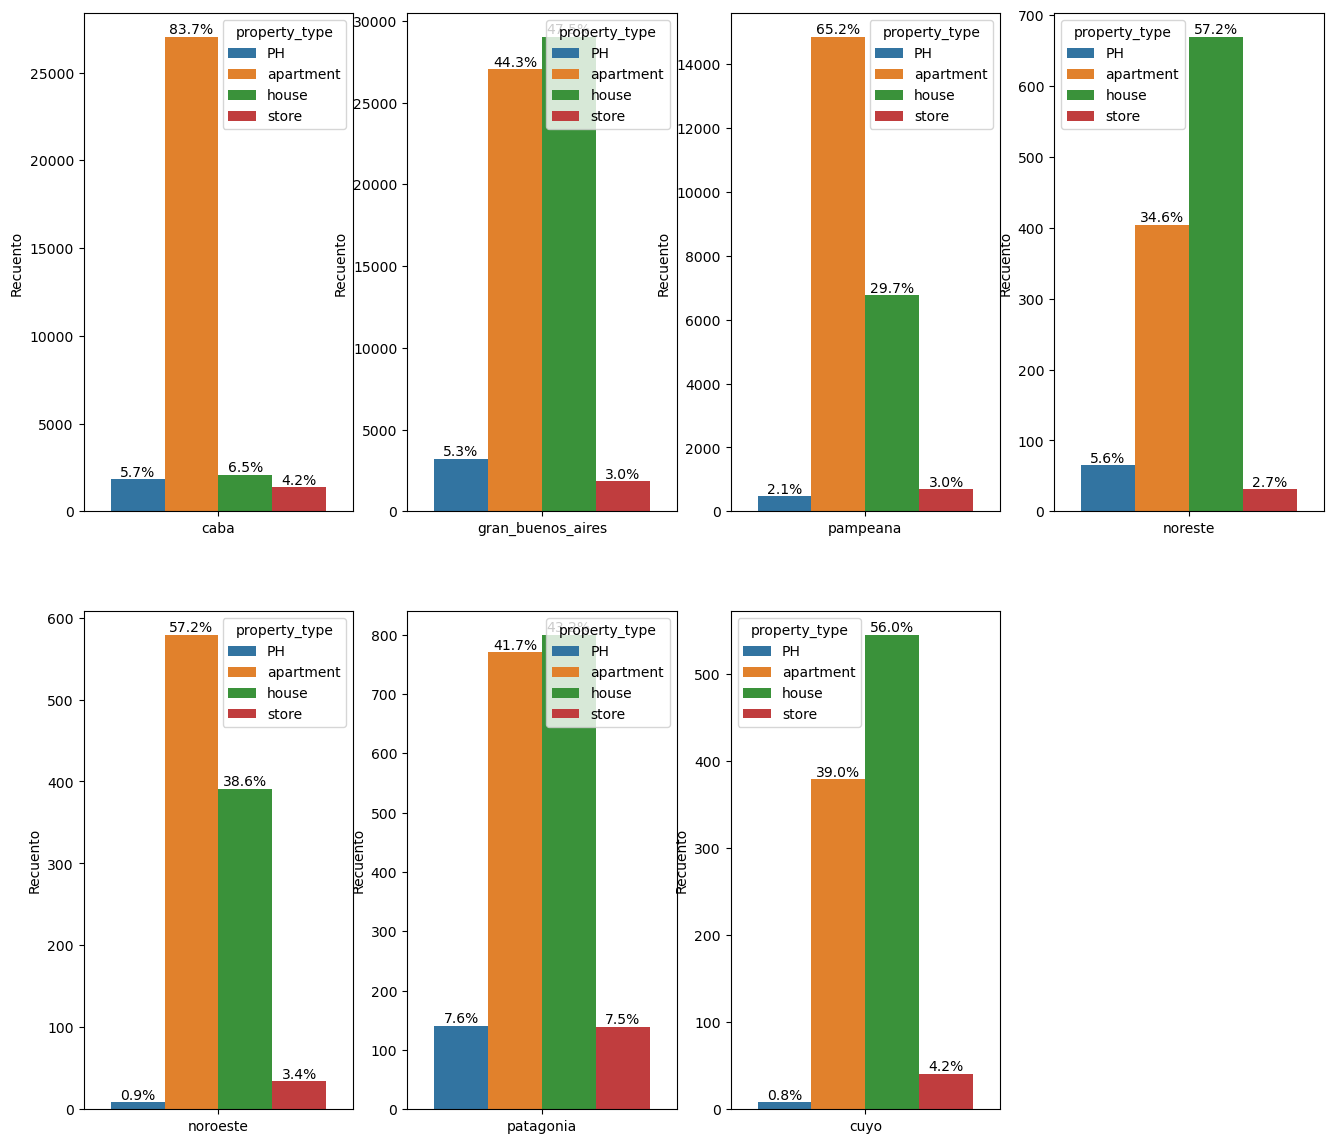

In [36]:
countplot_plot('region_name',"property_type", ylabel="Recuento" )

Analizar la distribucion de las diferentes propiedades en estos departamentos

### 3.1.6  Place_name

In [ ]:
# Busco los valores de place_name que me faltan

data.place_with_parent_names[data.place_name.isna()].value_counts()

|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||    23
Name: place_with_parent_names, dtype: int64

In [ ]:
# Observo que son todos de Tigre, asi que completo con Tigre
data.place_name.fillna("Tigre", inplace=True)

## 3.2 Análisis de variables numéricas

In [23]:
numerical.describe().T.round(1).sort_values(by='count' ,ascending=False)

,count,mean,std,min,25%,50%,75%,max
geonames_id,102503.0,3574442.3,354130.6,3427208.0,3430234.0,3433910.0,3836668.0,6948895.0
surface_covered_in_m2,101313.0,133.1,724.4,0.0,45.0,75.0,150.0,187000.0
price,100810.0,468525.9,2260100.6,0.0,110000.0,185000.0,420000.0,650000000.0
price_aprox_local_currency,100810.0,4229396.8,6904714.1,0.0,1583309.4,2558452.5,4675792.5,821271104.3
price_aprox_usd,100810.0,239700.6,391323.9,0.0,89733.9,145000.0,265000.0,46545445.0
price_per_m2,87658.0,6912.2,28378.6,1.5,1550.0,2213.1,3355.5,4000000.0
surface_total_in_m2,81892.0,233.8,1782.2,0.0,50.0,84.0,200.0,200000.0
lat,69670.0,-34.6,2.0,-54.8,-34.7,-34.6,-34.4,4.5
lon,69670.0,-59.3,2.3,-75.7,-58.7,-58.5,-58.4,-53.7
price_usd_per_m2,68617.0,2160.1,2759.3,0.6,1218.2,1800.0,2486.4,206333.3


# BUSCAR M2

1. Elegir entre covered y total m2 para compeltarlos.
2. Realizar m2 con los precios en dolares


In [150]:
# Creo 2 variables para organizar las features que me interesan y otra para descripton asi realizo regex para completar
data_m2 = data.loc[:,["surface_covered_in_m2", "surface_total_in_m2", "price_usd_per_m2", "price_per_m2"]]
data_description = data.loc[:,"description"]

In [151]:
# Nulos
data_m2.isna().sum()/data.shape[0]*100

surface_covered_in_m2    16.422208
surface_total_in_m2      32.443491
price_usd_per_m2         43.394654
price_per_m2             27.686850
dtype: float64

In [152]:
data_m2.describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered_in_m2,101313.0,133.050181,724.351479,0.000000,45.000000,75.000000,150.000000,1.870000e+05
surface_total_in_m2,81892.0,233.795328,1782.222147,0.000000,50.000000,84.000000,200.000000,2.000000e+05
price_usd_per_m2,68617.0,2160.086916,2759.288621,0.600000,1218.181818,1800.000000,2486.411765,2.063333e+05
price_per_m2,87658.0,6912.215705,28378.644734,1.510204,1550.000000,2213.114754,3355.548611,4.000000e+06


Observamos que en surface_covered_in_m2 y surface_total_in_m2 hay valores minimos de "0" y max de 187000, lo que son outliers y vAmos a tener que limpiarlos para que no afecte nuestro modelo. Esto se observa en la diferencia que hay entre media y mediana.

1. Tengo que elegir entre covered_m2 y total_m2. Decidiemos por total_m2 ya que es lo mas objetivo. En el Total se encuentran los m2 cubiertos ademas de los descubiertos, caracteristica que cambia el precio al comprar una propiedad ya que se utiliza los m2 totales. 
2. Vamos a compeltar los datos que no tenemos en totales con los cubiertos. Luego realizar regex. Y por lo ultimo, observar si hay datos en price_usd_per_m2 y price_per_m2 que reconvirtiendolo puedan darnos los m2.
3. Luego eliminaremos las varibales que tengan 0 ya que son outlier
4. Dividiremos el precio en dolares por los m2 para poder tener el target que nos interesa USD/m2


In [153]:
#1.A Completamos los valores de totales con los cubiertos
data_m2.surface_total_in_m2.fillna(data_m2.surface_covered_in_m2, inplace=True)

In [154]:
# Creamos nuestra columna de USD/m2  
data_m2["usd/m2"] = data.price_aprox_usd /data.surface_total_in_m2

In [155]:
data_m2.isna().sum()/data.shape[0]*100

surface_covered_in_m2    16.422208
surface_total_in_m2      10.203762
price_usd_per_m2         43.394654
price_per_m2             27.686850
usd/m2                   43.189243
dtype: float64

Disminuimos el porcentaje de NaN de m2 al 10%. Vamos a tratar de disminuir realizando regex en descripcion

In [156]:
# 1.B regex para encontar m2

import re
# defino funcion

def extract_description(pattern, data):
    #Primero paso a la columna a str para poder utilizar regex
    description_str = data["description"].astype(str)
    #Extraigo las frases que tenga un numero seguido por ambiente o amb en mayuscula o minuscula
    return description_str.str.extract(pattern, expand=False)

In [157]:
# Creo una mascara de los samples Nan
mask_m2 = data_m2.surface_total_in_m2.isna()
#Creo variable con solo estos samples
data_m2_describe = data.loc[mask_m2, ["description"]]

In [158]:
# Defino pattern 
pattern_m2 = re.compile(r"(m2\s*\d+|\d+\s*m2)", flags=re.IGNORECASE)

# Creo columna para checkear los diferentes valores que extraigo
data_m2_describe["check_m2"] = extract_description(pattern_m2, data_m2_describe)


In [159]:
#Observo que extraje correctamente valores que me interesaban
data_m2_describe.check_m2.unique()

array([nan, '83M2', '82M2', '460 m2', '375m2', '75 m2', '120 M2',
       '2290 m2', '80m2', '74m2', '7 M2', '400 M2', '35 m2', '45 M2',
       '160 m2', '1600 M2', '800 M2', '500m2', '68 m2', '150 M2',
       '225 m2', '150m2', '35m2', '4 m2', '15m2', '144M2', '25 m2',
       '155m2', '251 m2', '335m2', '1000 m2', '19M2', '480 m2', '903m2',
       '181 m2', '416 m2', '970 m2', '164 m2', '90 m2', '30m2', '88m2',
       '52m2', '38m2', '50m2', '830m2', '48 M2', '185 m2', '77 m2',
       '100 m2', '313 m2', '78 m2', '50 m2', '71 m2', '31 m2', '205 m2',
       '60 m2', '60m2', '83m2', '95m2', '1525 M2', '889 m2', '79 m2',
       '81 m2', '32m2', '10 m2', '36 m2', '82m2', '580m2', '1070 m2',
       '27 M2', '43m2', '00 m2', '400 m2', '90m2', '69 m2', '62 m2',
       '760 m2', '67 m2', '31 M2', '110 m2', '29 m2', '120 m2', '36m2',
       '375 m2', '510 m2', '151m2', '565m2', '42 m2', '120m2', '496 M2',
       '20M2', '69M2', '93 m2', '190m2', '100m2', '265m2', '50M2',
       '218 m2', '150 m

In [194]:
#Elimino los m2 y dejo solo el valor
regex_m2 = data_m2_describe.check_m2.str.replace(r"(m2)","" ,flags=re.IGNORECASE).astype(float)

#Elimino los valores menores a 1
regex_m2 =regex_m2.loc[regex_m2 > 1]

C:\Users\jpans\AppData\Local\Temp\ipykernel_13260\3341858453.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  regex_m2 = data_m2_describe.check_m2.str.replace(r"(m2)","" ,flags=re.IGNORECASE).astype(float)


2.0         13
3.0          2
4.0          4
5.0         18
6.0         20
            ..
9222.0       1
9980.0       1
11578.0      1
12000.0      1
420180.0     1
Name: check_m2, Length: 479, dtype: int64

In [196]:
#Completo los Nans con los valores que extraje de title
data_m2["surface_total_in_m2"].fillna(regex_m2, inplace=True)

In [162]:
# observo como quedaron los Nan
data_m2.isnull().sum()/data.shape[0]*100
# Disminuyo un 2 %

surface_covered_in_m2    16.422208
surface_total_in_m2       8.543970
price_usd_per_m2         43.394654
price_per_m2             27.686850
usd/m2                   43.189243
dtype: float64

In [163]:
# 1.C Comparo las columnas de Nan que me faltan para ver si puedo compeltarlo con las features price_usd_per_m2 y price_per_m2
# Creo de nuevo la mascara
mask_m2 = data_m2.surface_total_in_m2.isna()

#data_m2.loc[mask_m2,["surface_total_in_m2", "price_usd_per_m2", "price_per_m2"] ].isna().any()
# COnfirmo que en ninguna columna tengo valores para completar

In [164]:
# Vuelvo a completar mi columna usd_m2 con mis nuevos valores
data_m2["usd_m2"] = data.price_aprox_usd /data.surface_total_in_m2

In [165]:
#VEo como quedaron las features
data_m2.isnull().sum()/data_m2.shape[0]*100

# Observo que tengo un 23% de nulos en la columna USD/m2. Esto me demuestra que hay samples en donde tengo los m2 pero no los precios

surface_covered_in_m2    16.422208
surface_total_in_m2       8.543970
price_usd_per_m2         43.394654
price_per_m2             27.686850
usd/m2                   43.189243
usd_m2                   43.189243
dtype: float64

In [166]:
# Agrego los valores de m2 que consegui y la columna de usd/m2 a mi dataset original

#Agregar datos a m2_totales
data.surface_total_in_m2 = data_m2.surface_total_in_m2

#Agrego columna usd/m2
data["usd/m2"] = data_m2["usd/m2"]


In [167]:
data.columns

Index(['operation', 'property_type', 'place_name', 'place_with_parent_names',
       'country_name', 'state_name', 'geonames_id', 'lat-lon', 'lat', 'lon',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'region_name', 'usd/m2'],
      dtype='object')

# Precio

Completar los precios en dolares. 

1. Analizar valores de los 3 tipos de precios y ver sus caracteristicas
2. Comparar precio en dolares con moneda local para evaluar si hay algun valor que se pueda usar mediante conversion para rellenar un sample
3. Busqueda en price_usd_per_m2 y price_per_m2 para que mediante multiplicacion con los metros cuadrados se pueda sacar su precio total
4. Regex para completar los precios.

In [168]:
#1. Observacion de los tipos de precio

#Creo variable para mejor organizacion

data_price = data.loc[:, ["price", "price_aprox_local_currency","price_aprox_usd"]] 

In [169]:
data_price.describe().T

,count,mean,std,min,25%,50%,75%,max
price,100810.0,4.685259e+05,2.260101e+06,0.0,110000.00,185000.0,420000.0,650000000.0
price_aprox_local_currency,100810.0,4.229397e+06,6.904714e+06,0.0,1583309.44,2558452.5,4675792.5,821271104.3
price_aprox_usd,100810.0,2.397006e+05,3.913239e+05,0.0,89733.88,145000.0,265000.0,46545445.0


Se observa que hay valores minimos de 0, clara muestra de outliers. Solucionaremos esto mas adelante.

Todos tienen la misma cantidad de valores no nulos, pero se observa una diferencia entre sus estadisticos concordante con que cada feature maneja diferentes tipos de monedas. price_aprox_local_currency: Pesos ARG, price_aprox_usd: USD y price segun su moneda que en este caso son 'USD', 'ARS', 'PEN', 'UYU'.


In [170]:
# 2. Vamos a comparar las tres features apra ver si tienen los mismos valores faltantes

#Creo mascara para solo los Nan

mask_price_nan = data_price["price_aprox_usd"].isna()

data_price.loc[mask_price_nan, :].isna().all()

# Todos los precios tienen los mismis Nan


price                         True
price_aprox_local_currency    True
price_aprox_usd               True
dtype: bool

In [171]:
# 2. Comparo con los precio en m2 para ver si reconvirtiendo puedo completarlos

#Creo variable con las features que me interesan solo de los valores Nan de precio

data_price_m2  = data.loc[mask_price_nan, ["price_aprox_usd","price_usd_per_m2", "price_per_m2"]]

# Compruebo si son todos Nan
data_price_m2.isna().all()
# COnfirmo que no puedo completar con estas varaibles asi que paso a realizar regex

price_aprox_usd     True
price_usd_per_m2    True
price_per_m2        True
dtype: bool

In [172]:
#3. Realizo regex

# Creo variable con solo las columnas con precios Nan para mejor manejo
data_usd_description = data.loc[(mask_price_nan),["description"]]
#Observo brevemente como se distribuyen las descripciones. Para poder mejorar la lectura aumento la capacidad de texto que puedo leer
pd.set_option('max_colwidth', 450)
data_usd_description.head(20)

,description
5,"Casa en el perímetro del barrio 338, ubicada en el extremo sur este del barrio, sobre calle 3 de caballería casi Nágera. Vista libre a terreno en frente.Consta de dos dormitorios, baño, living cocina comedor integrado de buen tamaño, lavadero con despensero en aluminio.Patio privado con churrasquera, tapiales y puerta de acceso de servicio. Frente con rejas y pequeño patio con verde, porch de acceso.Gas natural en la puerta. Aire acondicionad..."
20,"Consta de: Comedor-cocina, cuatro dormitorios (uno con baño en suite), un baño, otro baño para terminar, cuarto de herramientas y amplio parque."
41,"“Arecas” es un complejo de dúplex y departamentos de primera calidad constructiva ubicado en el mejor Barrio Residencial de Villa Carlos Paz. Pensamos en brindarles una opción acorde a cada necesidad: para la persona o familia que busca su vivienda, el ahorrista que elige una vivienda en construcción para capitalizarse y el inversionista que apuesta a la excelente renta que ofrece la Villa en alquileres temporarios. • Financiación: FINANCIACI..."
62,"Casa moderna en dos plantas.PB : Living con hogar, cocina-comedor diario, toilette de recepción, lavadero y estudio, todos los pisos de cerámicos, carpinterí­a exterior en aluminio blanco con doble vidrio.PA: Hall de distribución, con pequeño espacio para escritorio y placard. Dos dormitorios, baño compartido y suite con vestidor. Todos los pisos flotantes."
67,PLANTA ALTA: DORMITORIO EN SUITE - BALCÓNPLANTA BAJA: 2 DORMITORIOS - BAÑO - COCINA - LIVING/COMEDOR - LAVADERO - PATIO- FONDO LIBRE- ENTRADA DE AUTO - LOCAL CON BAÑOCONSULTE VALOR
76,"Impecable casa moderna ubicada en la loma de Stella Maris. Consta de amplia recepcion, toilette, cocina comedor, 3 dormitorios (principal en suite), garage p/ 4 autos, quincho con parrilla, dependencia de servicio con baño y gran parque. La calefaccion es por radiadores. Consulte."
83,"IDEAL INVERSORES o ESTUDIANTES APTA CREDITO Antigüedad 30 años Superficie cubierta: 55 m2 Contrafrente, interno Ingreso a living-comedor con cocina anexa (ventila naturalmente) Pasillo distribuidor a baño con ducha completa y dos dormitorios. Construcción solida con pisos de cerámica en estado inmaculado, puerta con doble cerradura. Seguridad fines de semana y lunes a viernes de (22 a 6 am) y cámaras de vigilancia. - Publicado por"
84,"Departamento en PB con cocina comedor separado. Instalación y sector para lavarropas. Estar, 1 baño y 2 dormitorios con placares. Patio de uso compartido. En Buen estado Cuenta con cochera cubierta en planta baja (Medidas 2.50 x 5.00 m) Edificio de PB y dos pisos con escalera. MUY BAJAS EXPENSAS NO APTA CREDITO - Publicado por"
85,"Corrientes 1900 – 1º Piso Departamento de 1 dormitorio (semipiso) Cocina con alacena y bajo mesada semi-integrada al living comedor. Instalación para lavarropas. Circulación o paso hacia baño y dormitorio. 1 dormitorio con vista despejada hacia el Noreste. Muy luminoso. Placares con interiores. Baño con bañera. Balcón Terraza, muy amplio. Posibilidad de instalar parrillero. Antigüedad 2 años FRENTE, orientación Oeste Superficie total: 63 m2 E..."
100,San Nicolás 365ENTREGA INMEDIATA.Edificio de escaleraPlanta baja y 3 pisosCompuesto de:4 Departamentos dos dormitorios7 Departamentos un dormitorio7 Monoambientes3 Cocheras. 4404242 / 4403232Santa Fe Piso 6 Oficina 42000 | Rosario | Santa Fe | Argentina Horario de Atención: Lunes a Viernes de 10.00 a 18.00. EasyBroker ID: EB-AI0748


In [173]:
# Reinicio el tamaño para ve la descripcion
pd.reset_option("max_colwidth")


In [174]:
# Como osbervo que hay varios valores que corresponden a alquiler voy a eliminar estos samples para evitar confusion
alquiler_pattern = re.compile(r"(alquilado|alquiler|alquilo|alquilar)", flags=re.IGNORECASE )

describe_alquiler = extract_description(alquiler_pattern, data_usd_description)

#Observo que capto correcamente los valores
describe_alquiler.unique()

array([nan, 'alquiler', 'Alquilado', 'ALQUILADO', 'alquilado', 'ALQUILER',
       'alquilar', 'Alquiler', 'ALQUILAR', 'ALQUILO', 'Alquilo'],
      dtype=object)

In [175]:
# Drope esos valores de la variable que cree
data_usd_description.drop(data_usd_description[describe_alquiler.notnull()].index, inplace=True)

data_usd_description

,description
5,"Casa en el perímetro del barrio 338, ubicada e..."
20,"Consta de: Comedor-cocina, cuatro dormitorios ..."
62,Casa moderna en dos plantas.PB : Living con ho...
67,PLANTA ALTA: DORMITORIO EN SUITE - BALCÓNPLANT...
76,Impecable casa moderna ubicada en la loma de S...
...,...
121208,Puertos- Barrio Vistas - L. 88Casa en venta so...
121210,Dos viviendas en block en excelente ubicación ...
121211,Excelente departamento de categoría con vistas...
121212,ESPECTACULAR CASA ESTILO RACIONALISTA EN CALLE...


In [176]:
# Creo pattern para dolares y pesos separados ya que los pesos tengo que convertirlos us\$
usd_pattern = re.compile(r"(\d*\.*\d*\.*\d+\s*u\$s|u\$s\s*\d+\.*\d*\.*\d*|\d*\.*\d*\.*\d+\s*usd|usd\s*\d+\.*\d*\.*\d*|\d*\.*\d*\.*\d+\s*us\$?|us\$?\s*\d+\.*\d*\.*\d*)", flags=re.IGNORECASE)

#Extraigo los valores con usd, u$d o us 
describe_usd = extract_description(usd_pattern,data_usd_description)

In [177]:
describe_usd.value_counts()

USD 1          217
U$S 1          181
u$s20.000.      66
U$S 40.0002     32
USD45.000       32
              ... 
U$S 335.000      1
U$S 343.000      1
U$S 445.000      1
U$S 67.000.      1
USD 30.000       1
Name: description, Length: 321, dtype: int64

In [178]:
# Elimino los valores con null porque me alteran el resultado
describe_usd = describe_usd[describe_usd.str.contains("null") == False]

#Reemplazo las palabras por espacio y lo convierto en float 
describe_usd = describe_usd.str.replace(r"(\D)","", flags=re.IGNORECASE).astype(float)

#Elimino los valores menores a 1
describe_usd =describe_usd.loc[describe_usd > 1]

C:\Users\jpans\AppData\Local\Temp\ipykernel_13260\2892007751.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  describe_usd = describe_usd.str.replace(r"(\D)","", flags=re.IGNORECASE).astype(float)


In [179]:
# Observo como tengo los valores ya separados de sus letras. Tambien veo que hay valores muy bajos. Estos los eliminares mas adelante
describe_usd.value_counts()

20000.0     82
45000.0     40
400002.0    32
120006.0    26
25000.0     22
            ..
335000.0     1
343000.0     1
445000.0     1
67000.0      1
34000.0      1
Name: description, Length: 229, dtype: int64

In [180]:
# Dropeo los valores ya seleccionados para evitar que se solapen con los de pesos
#data_usd_description_pesos = data_usd_description.drop(data_usd_description[describe_usd.notnull()].index)

In [181]:
# Ahora lo realizo con los pesos
# Creo pattern pesos
peso_pattern = re.compile(r"(\d*\.*\d*\.*\d+\s*\$|\$\s*\d+\.*\d*\.*\d*)", flags=re.IGNORECASE)

describe_pesos = extract_description(peso_pattern,data_usd_description)

In [182]:
# Elimino los valores con null porque me alteran el resultado
describe_pesos = describe_pesos[describe_pesos.str.contains("null") == False]

#Reemplazo las palabras por espacio y lo convierto en float 
describe_pesos = describe_pesos.str.replace(r"(\D)","", flags=re.IGNORECASE).astype(float)

#Elimino los valores menores a 1
describe_pesos =describe_pesos.loc[describe_pesos > 1]

C:\Users\jpans\AppData\Local\Temp\ipykernel_13260\2161296386.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  describe_pesos = describe_pesos.str.replace(r"(\D)","", flags=re.IGNORECASE).astype(float)


In [183]:
# Observo los valores de pesos. Nuevamente veo valores extremos. 
describe_pesos.value_counts()

420000.0    34
4500.0      21
1000.0      20
1500.0      13
400000.0    12
            ..
548625.0     1
150.0        1
120000.0     1
1217.0       1
3400.0       1
Name: description, Length: 277, dtype: int64

In [184]:
# Multiplico los pesos al precio del dolar de esa epoca
describe_pesos_convert_dolar = describe_pesos/17.64


In [185]:
# Ahora uno las dos variables para tener una
describe_pesos_and_dolar = describe_usd.fillna(describe_pesos_convert_dolar)

In [186]:
data["price_aprox_usd"].fillna(describe_pesos_and_dolar, inplace=True)
data["usd/m2"] = data.price_aprox_usd /data.surface_total_in_m2

In [187]:
data.isna().sum()/data.shape[0]*100

operation                      0.000000
property_type                  0.000000
place_name                     0.000000
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.280317
surface_total_in_m2            8.543970
surface_covered_in_m2         16.422208
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000
image_thumbnail                2.567233


### Grafico el precio


Queda pendiente eliminar los outliers ya que son varios y graficar correctamente 

# extra

In [58]:
# Valor del Dolar 
#Dividimos el precio en pesos por dolar para obtener valor y lo reodndeamos a 2 
usd = round(data.price_aprox_local_currency.div(data.price_aprox_usd),2)

# Observamos que el valor unico es 17.64
usd.unique()

array([17.64,   nan])

# Expensas:

In [59]:
patron_expensas="(?P<Expensas1>(\sEXPENSAS\:\s\d+)|(\sexpensas\:\s\d+)|(\sEXPENSAS\s\d+)|(\sexpensas\s\d+)|(\d+\sEXPENSAS\s)|(\d+\sexpensas\s)(\sEXPENSA\:\s\d+)|(\sexpensa\:\s\d+)|(\sEXPENSA\s\d+)|(\sexpensas\s\d+)|(\d+\sEXPENSA\s)|(\d+\sexpensa\s)|(Expensas\:\s\$\s\d\W\d+)|(\sExpensas\:\s\$\s\d\W\d+)|(EXPENSAS\:\s\$\s\d\W\d+)|(\sEXPENSAS\:\s\$\s+\d\W\d+)|(Expensas\:\s\$\s\d+\W\d+)|(\sExpensas\:\s\$\s\d+\W\d+)|(EXPENSAS\:\s\$\s\d+\W\d+)|(\sEXPENSAS\:\s\$\s\d+\W\d+)|(Expensas\:\su\$s\s\d+)|(\sExpensas\:\su\$s\s\d+)|(Expensas\:\su\$s\s\d+\W\d+)|(\sExpensas\:\su\$s\s\d+\W\d+)|(Expensas\su\$s\s\d+)|(\sExpensas\su\$s\s\d+)|(Expensas\su\$s\s\d+\W\d+)|(\sExpensas\su\$s\s\d+\W\d+)|(EXPENSAS\:\su\$s\s\d+)|(\sEXPENSAS\:\su\$s\s\d+)|(Expensas\:\su\$s\s\d+\W\d+)|(\sEXPENSAS\:\su\$s\s\d+\W\d+)|(EXPENSAS\su\$s\s\d+)|(\sEXPENSAS\su\$s\s\d+)|(EXPENSAS\su\$s\s\d+\W\d+)|(\sEXPENSAS\su\$s\s\d+\W\d+))"

expensas_pattern_regex = re.compile(patron_expensas)

data_expensas_match = data['description'].apply(lambda x:  x if x is np.NaN else expensas_pattern_regex.search(x))

mask_data_expensas_match_notnull = data_expensas_match.notnull()

data.loc[mask_data_expensas_match_notnull, "ObjectExpensesDescription"] = data_expensas_match[mask_data_expensas_match_notnull].apply(lambda x: x.group("Expensas1"))

In [60]:
#verifico los campos expensas, descripción y el campo patrón:
data_aux_expensas= data.loc[mask_data_expensas_match_notnull, ["description", "expenses","ObjectExpensesDescription"]]
data_aux_expensas

,description,expenses,ObjectExpensesDescription
143,"EDIFICIO - MeirLiving, cocina, dormitorio , ba...",NaN,Expensas: $ 1.300
167,Corredor Responsable: Mariano Aufseher - CUCIC...,NaN,EXPENSAS: $ 1.600
215,"Ideal tienda comercial, no apto gastronómico.L...",NaN,Expensas: $ 1.000
323,- Absolutamente impecable tres ambientes en pl...,NaN,Expensas: $ 2.000
341,Corredor Responsable: Cristian Arnal Ponti - C...,NaN,Expensas: $ 4.700
...,...,...,...
118693,Corredor Responsable: Rebeca Stern - C.U.C.I.C...,NaN,Expensas: $ 2.200
118780,"Excelente 3 ambientes en 4° piso al frente, en...",1500.0,Expensas: $ 1.500
119120,"LIVING/COMEDOR, BALCON TERRAZA, TOILETTE, COCI...",NaN,Expensas: $ 5.600
119270,Corredor Responsable: Gustavo Guastello - C.U....,NaN,expensas 34


# Floor:

In [61]:
patron_floor= "(?P<floor1>(\d+\spiso\s)|(piso\s\d+))"

floor_pattern_regex = re.compile(patron_floor)

data_floor_match = data['description'].apply(lambda x:  x if x is np.NaN else floor_pattern_regex.search(x))

mask_data_floor_match_notnull = data_floor_match.notnull()

data.loc[mask_data_floor_match_notnull, "ObjectFloorDescription"] = data_floor_match[mask_data_floor_match_notnull].apply(lambda x: x.group("floor1"))

In [62]:
#verifico los campos floor, descripción y el campo patrón:
data_aux_floor= data.loc[mask_data_floor_match_notnull, ["description", "floor","ObjectFloorDescription"]]
data_aux_floor

,description,floor,ObjectFloorDescription
17,Excelente 3 ambientes en un 6 piso y con terra...,NaN,6 piso
33,Excelente 3 ambientes en un 6 piso en esquina ...,NaN,6 piso
48,"PISO 13, Orientación norte, disposición al fre...",NaN,piso 13
96,"Departamento de 2 ambientes, ubicado en la cos...",3.0,piso 3
120,"Depto de 3 amb. c/cochera cubierta, en piso 12...",12.0,piso 12
...,...,...,...
121052,Torre de 16º pisos ubicado en pleno centro com...,NaN,piso 16
121152,Monoambiente divisible en 3 piso al frente con...,NaN,3 piso
121157,Torre de 16º pisos ubicado en pleno centro com...,NaN,piso 16
121160,Edificio en esquina de muy buena categoría de ...,NaN,piso 1


<AxesSubplot:>

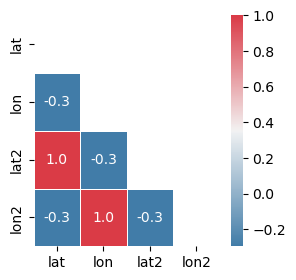

In [71]:
#chequeo que lat-lon sea igual a lat y lon juntos
#separo y spliteo columna lat-lon

data_lat_lon = data["lat-lon"].str.split(",", expand = True)
data_lat_lon
lat2 = data_lat_lon[0].astype(float)
lon2 = data_lat_lon[1].astype(float)

#creo dataframe com lat, lat2, lon y lon2 y correlaciono

data_lat_lon_correlation = pd.DataFrame({"lat": data["lat"], "lon": data["lon"], "lat2": lat2, "lon2": lon2}).corr()

fig,ax = plt.subplots(figsize=(3, 3))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
matrix = np.triu(data_lat_lon_correlation)
sns.heatmap(data_lat_lon_correlation, annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=cmap, mask=matrix)

In [75]:
# Elimino columna lat-lon
data.drop(labels="lat-lon", axis=1, inplace=True)

In [270]:
# Crear columna geometry con lat y lon

geometria = gpd.points_from_xy(data.lon, data.lat)
geo_arg = gpd.GeoDataFrame(data, geometry=geometria)

## Ejemplo para graficar

In [271]:
geo_arg = geo_arg.loc[:, ["lat", "lon", "geometry", "region_name", "place_name"]].dropna()
geo_arg

,lat,lon,geometry,region_name,place_name
0,-34.661824,-58.508839,POINT (-58.50884 -34.66182),caba,Mataderos
1,-34.903883,-57.964330,POINT (-57.96433 -34.90388),gran_buenos_aires,La Plata
2,-34.652262,-58.522982,POINT (-58.52298 -34.65226),caba,Mataderos
3,-34.647797,-58.516424,POINT (-58.51642 -34.64780),caba,Liniers
4,-38.002626,-57.549447,POINT (-57.54945 -38.00263),gran_buenos_aires,Centro
...,...,...,...,...,...
121153,-34.599214,-58.402519,POINT (-58.40252 -34.59921),caba,Barrio Norte
121158,-34.587425,-58.397372,POINT (-58.39737 -34.58743),caba,Recoleta
121160,-34.563685,-58.442683,POINT (-58.44268 -34.56369),caba,Belgrano
121209,-34.563685,-58.442683,POINT (-58.44268 -34.56369),caba,Belgrano


In [272]:
# Creo una variabl 
geo_arg_ba = geo_arg[geo_arg["region_name"] == "caba"]

In [273]:
mask_max = geo_arg_ba["lat"] > (-35	)
geo_arg_ba = geo_arg_ba.loc[mask_max]
geo_arg_ba

,lat,lon,geometry,region_name,place_name
0,-34.661824,-58.508839,POINT (-58.50884 -34.66182),caba,Mataderos
2,-34.652262,-58.522982,POINT (-58.52298 -34.65226),caba,Mataderos
3,-34.647797,-58.516424,POINT (-58.51642 -34.64780),caba,Liniers
7,-34.559873,-58.443362,POINT (-58.44336 -34.55987),caba,Belgrano
8,-34.559873,-58.443362,POINT (-58.44336 -34.55987),caba,Belgrano
...,...,...,...,...,...
121153,-34.599214,-58.402519,POINT (-58.40252 -34.59921),caba,Barrio Norte
121158,-34.587425,-58.397372,POINT (-58.39737 -34.58743),caba,Recoleta
121160,-34.563685,-58.442683,POINT (-58.44268 -34.56369),caba,Belgrano
121209,-34.563685,-58.442683,POINT (-58.44268 -34.56369),caba,Belgrano


<AxesSubplot:xlabel='lat', ylabel='lon'>

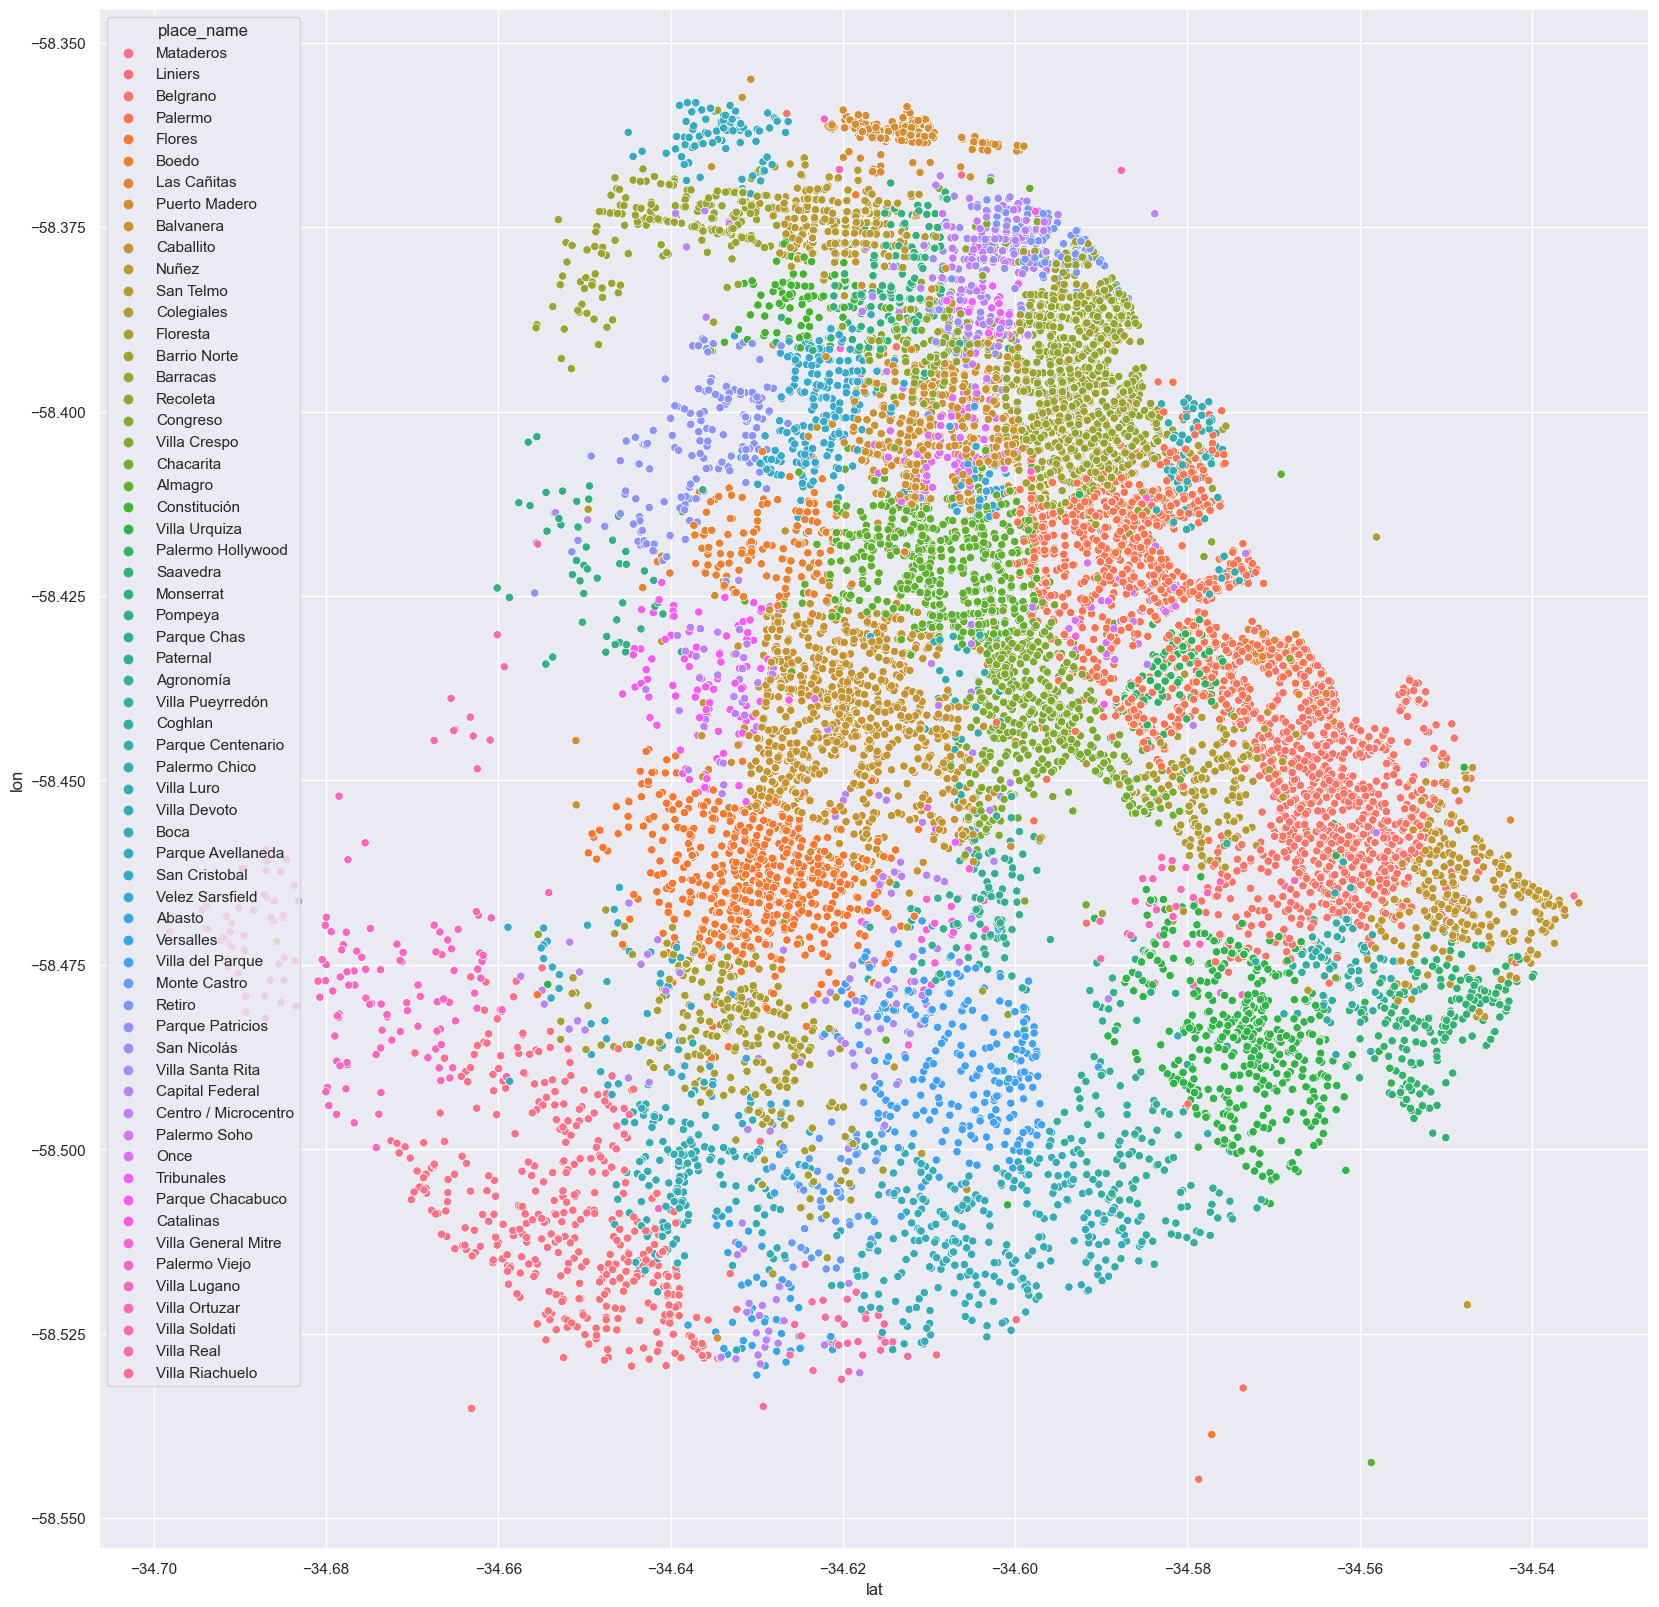

In [274]:
sns.set(rc={"figure.figsize":(20, 20)})
sns.scatterplot(data=geo_arg_ba, x="lat", y="lon", hue="place_name")